# Benchmark: anomalous diffusion
> We benchmark STEP study anomalous diffusion with changes.

In [ ]:
#| hide
from step.data import *
from step.utils import *
from step.models import *
from step.baselines import *

from tqdm.auto import tqdm
from fastai.vision.all import *

The main goal is to characterize anomalous diffusion processes that switch between diffusive states without any kind of prior konwledge. In this tutorial, we focus on inferring the anomalous diffusion exponent $\alpha$ at every time step, which naturally highlights potential changes in the behaviour along the trajectories. This allows us to obtain a deeper understanding of the underlying physical systems that drive the dynamics. 

In the following analysis, we provide a thorough characterization of the model performance under various conditions and we show how to reproduce some figures of [our paper](https://arxiv.org/abs/2302.00410).

::: {.callout-note}
This tutorial is very similar to the [Benchmark: Brownian motion](https://borjarequena.github.io/step/tutorials/analysis_bm.html). Thus, we skip some extended explanations here and we refer to this one instead. 
:::

# Load the model
First of all, we need to load a trained model with which to perform the analysis.

::: {.callout-note}
We refer to the [model training tutorial](https://borjarequena.github.io/step/tutorials/model_training.html) for details about how to train and save your models.
:::

To load the models within a `Leaner`, we need to provide some data loaders. However, we will use the model to study various scenarios, so we provide an empty dataloader and load the different data sets as we need them.

In [ ]:
dim = 2
dls = DataLoaders.from_dsets([], []) # Empty train and validation datasets
model = XResAttn(dim, n_class=1, stem_szs=(32,), conv_blocks=[1, 1, 1],
                 block_szs=[128, 256, 512], pos_enc=False,
                 n_encoder_layers=4, dim_ff=512, nhead_enc=8, linear_layers=[])
model.to(default_device())
learn_exp = Learner(dls, model, loss_func=L1LossFlat(), model_dir=MODEL_PATH)

Now we can load the trained model weights.

In [ ]:
learn_exp.load(f'xresattn_exp_{dim}d_1_to_4_cp')
learn_exp.model.eval();

::: {.callout-warning}
It is very important to define the model exactly with the same layers as we did during training. Otherwise, we won't be able to load the trained parameters!
:::

# Pointwise prediction

We study the overall performance of the method over anomalous diffusion trajectories that present changes both in the underlying anomalous diffusion model, and the anomalous diffusion exponent $\alpha$. We look at the pointwise prediction error and study how the length of the segments within the trajectory affect it.

We compare our approach with a reference method based on the time-averaged mean squared displacement (TA-MSD) (see [baselines](https://borjarequena.github.io/step/source/baselines.html)). However, since this method cannot account for any heterogeneity in the trajectories, we provide it with the pre-segmented trajectories. This results in a massive advantage and, thus, we also pass the pre-cut segments through our model.

With this segment-wise analysis, we can easily study the performance of all the methods as function of the segment lengths. 

## Generate the data

To evaluate the different methods, we need a proper test set. We can generate one in the same way that we genereate the train set in the [model training tutorial](https://borjarequena.github.io/step/tutorials/model_training.html).

::: {.callout-note}
Skip the data generation if you already have a test set!
:::

In [ ]:
# OPTIONAL: create the test set.
# Don't need to run this cell if it already exists.
n_per_set = 12500
max_t = 200
dim = 2 
cps = [1, 2, 3, 4]
ds_fun = partial(create_andi_segmentation_dataset,
                 max_t=max_t, dim=dim, noise=[0.], save=False)
datasets = [ds_fun(n_per_set, n_change_points=n_cp) for n_cp in cps]
dataset = combine_datasets(datasets)
n_change = f"{min(cps)}_to_{max(cps)}"
save_path = DATA_PATH/get_andids_fname(n_change, max_t, dim, "test")
dataset.to_pickle(save_path)

Load the test set.

In [ ]:
# Skip this cell if you just generated it.
n_change = "1_to_4"
name = "test"
ds = load_dataset(n_change=n_change, dim=dim, name=name)

## Get the predictions

We now perform the predictions of the trajectories store them in the dataframe to process them later. First, we compute the full-trajectory predictions. Then, we proceed with the segment-wise analysis. We split the trajectories and their predictions by the *true* changepoints. Then, we perform the prediction especifically for each segment with both the model and the TA-MSD method. We use the TA-MSD 2-10 to perform the evaluation.

Let's define a prediction function and a normalization function to simplify the code.

In [ ]:
def predict_norm_sample(model, x):
    "Get the `model` prediction normalizing a single sample `x`."
    xb = x.unsqueeze(0).to(default_device())
    xb_norm = normalize(xb)[0]
    return to_detach(model(xb_norm).squeeze())

def normalize(trajs):
    "Normalize a batch of trajectories."
    bs, _, dim = trajs.shape
    trajs -= trajs.mean(1, keepdim=True)
    displ = trajs[:, 1:] - trajs[:, :-1]
    std = displ.std(1, keepdim=True)
    std = torch.where(std == 0., torch.ones_like(std), std)
    displ /= std
    trajs_norm = displ.cumsum(1)
    trajs_norm = torch.cat([torch.zeros(bs, 1, dim, device=trajs.device),
                            trajs_norm], axis=1)
    return trajs_norm, std

Now we can proceed to process the trajectories. In the following piece of code, we process every trajectory (outer loop). Then, we split it into segments with constant properties (inner loop), and we compute the mean absolute error (MAE) and the mean relative error with the three aforementioned approaches.

In [ ]:
max_samples = 50000 # Subsample 50k trajectories
segment_data = []

for i, row in tqdm(ds[:max_samples].iterrows()):
    x, y = row.x, row.y_exp.squeeze()
    y_mod, cps = row.y_mod.squeeze(), row.cp
    
    # Predict over full trajectory
    pred = predict_norm_sample(learn_exp.model, x.T)
    
    # Segment trajectory with true changepoints
    split_x, split_pred = split_tensor(x.T, cps), split_tensor(pred, cps)
    split_y, split_model = split_tensor(y, cps), split_tensor(y_mod, cps)
    splits = zip(split_x, split_y, split_model, split_pred)
    for j, (seg_x, seg_y, seg_model, pred_cut) in enumerate(splits):
        # Prediction over full trajectory cut with true changepoints
        mae = mean_absolute_error(pred_cut, seg_y)
        
        # Add noise to flat CTRW segments for numerical stability
        if (seg_x - seg_x[0]).allclose(tensor(0.)):
            seg_x += 0.1*torch.randn_like(seg_x)
        
        
        # Prediction over segment
        pred_segment = predict_norm_sample(learn_exp.model, seg_x - seg_x[0])
        mae_segment = mean_absolute_error(pred_segment, seg_y)
        
        # Prediction over segment with TA-MSD
        pred_tamsd = anomalous_exponent_tamsd(seg_x)
        mae_tamsd = mean_absolute_error(pred_tamsd, seg_y[0])
        
        segment_data.append({'sample': i, 'segment_idx': j,
                             'length': len(seg_y), 'x': seg_x, 'y': seg_y,
                             'model': seg_model[0], 'pred_cut': pred_cut, 
                             'pred_segment': pred_segment,
                             'pred_tamsd': pred_tamsd, 'mae': mae,
                             'mae_segment': mae_segment,
                             'mae_tamsd': mae_tamsd})
ds = pd.DataFrame.from_records(segment_data)

Unlike in the normal diffusion case, we encounter some numerical instabilities with the methods when we provide them with the split segments. We purge all the broken predictions to proceed with the analysis.

In [ ]:
mask_full = ds.mae.apply(lambda x: torch.isnan(x).item())
mask_tamsd = ds.mae_tamsd.apply(lambda x: torch.isnan(x).item())
mask_seg = ds.mae_segment.apply(lambda x: torch.isnan(x).item())
mask = (mask_full | mask_tamsd | mask_seg)
ds = ds[~mask]

We can save all the data for further posterior processing.

In [ ]:
ds.to_pickle(DATA_PATH/'segment_analysis_alpha_test.pkl')

## Prediction error

Let's quantify the model performances by computing their MAE over full trajectories and trajectory segments.

In [ ]:
lengths = ds.length.unique().astype(int)
lengths.sort()

metrics = ['mae', 'mae_segment', 'mae_tamsd']
metric_by_length = {m: {'mean': [], 'sem': [], 'global': None}
                    for m in metrics}

for m in metrics:
    means = [getattr(ds, m)[ds.length == l].mean()
             for l in lengths]
    sems = [getattr(ds, m)[ds.length == l].sem()
            for l in lengths]
        
    metric_by_length[m]['mean'] = np.array(means)
    metric_by_length[m]['sem'] = np.array(sems)
    metric_by_length[m]['global'] = (
        (getattr(ds, m)*ds.length).sum() / 
        ds.length.sum()
    )

Save this for later.

In [ ]:
name = "mae_segment_length"
data_path = (FIG_PATH/name).with_suffix(".pkl")

with open(data_path, 'wb') as f:
    pickle.dump(metric_by_length, f, protocol=pickle.HIGHEST_PROTOCOL)

Let's see the overall MAE for each method.

In [ ]:
#| code-fold: true
print(f"STEP: {metric_by_length['mae']['global']:.3f}")
print(f"STEP + segments: {metric_by_length['mae_segment']['global']:.3f}")
print(f"TA-MSD + segments: {metric_by_length['mae_tmsd']['global']:.3f}")

STEP: 0.271
STEP + segments: 0.275
TA-MSD + segments: 0.368


STEP outperforms the TA-MSD baseline, reducing the overall error by more than $25\%$. The advantage is significantly larger in short segments, as we see below. 

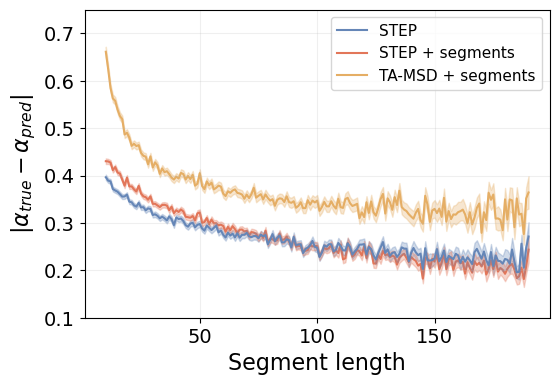

In [ ]:
#| code-fold: true
fig = plt.figure(figsize=(1.5*fig_size, fig_size))
lengths = np.arange(10, 191)
labels = ['STEP', 'STEP + segments', 'TA-MSD + segments']
for i, m in enumerate(metric_by_length.keys()):
    mean, sem = metric_by_length[m]['mean'], metric_by_length[m]['sem']
    label = labels[i//2]# if i%2 == 0 else None
    plt.plot(lengths, mean, linestyle='-', color=colors[i//2], label=label,
                    zorder=10 if i==0 else -1)
    plt.fill_between(lengths, mean - sem, mean + sem, color=colors[i//2], alpha=0.3)
plt.grid(alpha=alpha_grid)
plt.legend(fontsize=11)
plt.tick_params(labelsize=14)
plt.ylim([0.1, 0.75])
plt.xlabel("Segment length", fontsize=16)
plt.ylabel(r"$|\alpha_{true} - \alpha_{pred}|$", fontsize=16);

In this case, the TA-MSD-based method does never reach the performance level of STEP, even in very long segments. This is in contrast to the [Brownian motion benchmark](https://borjarequena.github.io/step/tutorials/analysis_bm.html#prediction-error), where the TA-MSD method attains a similar performance for the longest segments.

Additionally, in this case, feeding STEP with segments harms the performance in the shortest segments. As we have mentioned previously, doing this causes some numerical issues with the methods (both STEP and the TA-MSD). Regardless, the pre-segmented trajectories are never available in real scenarios.

## Error by anomalous diffusion model

The anomalous diffusion models that we consider describe very different behaviours. The deviation from normal diffusion has different sources in each of them and, therefore, their anomalous diffusion exponent $\alpha$ depends on different phenomena.

Hence, it is reasonable to expect the underlying anomalous diffusion model of each segment to play a key role in the characterization. Furthermore, every model has a different range for $\alpha$:

- Annealed transit time (ATTM) with $\alpha\in\left[0.05, 1\right]$.
- Continuous time random walk (CTRW) with $\alpha\in\left[0.05, 1\right]$.
- Fractional Brownian motion (FBM) with $\alpha\in\left[0.05, 1.95\right]$.
- Lévy Walk (LW) with $\alpha\in\left[1.05, 2\right]$.
- Scaled Brownian motion (SBM) with $\alpha\in\left[0.05, 2\right]$.
 
The wider the $\alpha$ range, the larger the errors can become. Let's look at the MAE for each method.

In [ ]:
mae_by_model = [ds[(ds.model == m)].mae.mean()
                for m in MODEL_DATA.keys()]

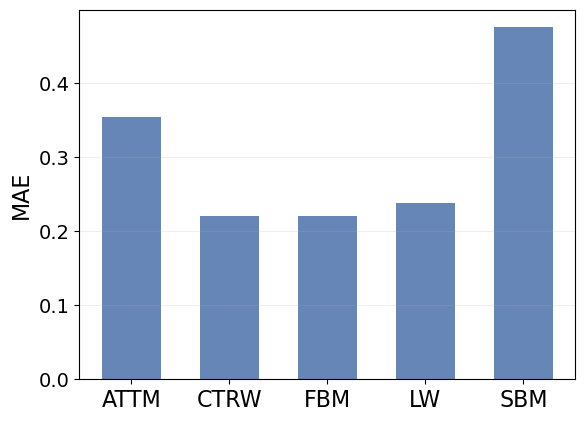

In [ ]:
#| code-fold: true
x = np.arange(5)
plt.bar(x, mae_by_model, color=colors[0], width=0.6)
plt.grid(axis='y', alpha=alpha_grid)
plt.ylabel('MAE', fontsize=16)
plt.xticks(x, [MODEL_DATA[n]['name'].upper() for n in x])
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=14)

CTRW, FBM and LW have similar MAE. Surprisingly, FBM holds the lowest error while having one of the largest ranges for $\alpha$. Then, ATTM and SBM are clearly the hardest models to characterize, as their MAE is between $50\%$ to $100\%$ larger than the other methods.

In SBM, as we will see in the next tutorial, $\alpha$ is related to the ageing of the diffusion coefficient. This means that we need long segments to correctly characterize $\alpha$.

::: {.callout-note}
SBM was also found to be the hardest model to characterize in the [AnDi Challenge](https://www.nature.com/articles/s41467-021-26320-w).
:::

Let's bring this study further to get a better idea about the sources of errors in all the models, such as ATTM. 

## Error by diffusion model and localization noise

Let's study the behaviour of STEP for each diffusion model in more detail and, at the same time, study its resilience to localization noise.

In [ ]:
# Optional: load the test set if it is not in memory
ds = load_dataset(n_change="1_to_4", dim=dim, name="test")

To make the computation more bearable, we work with a fraction of our full test set.

In [ ]:
ds = ds.sample(frac=0.25, random_state=0).reset_index(drop=True)

In [ ]:
ds['y'] = ds['y_exp'].apply(torch.squeeze)
ds['model'] = ds['y_mod'].apply(torch.squeeze)
ds = ds.drop(columns=['y_mod', 'y_exp', 'models', 'exps', 'noise'])

### Process the trajectories

Similar to the [Brownian motion analysis](https://borjarequena.github.io/step/tutorials/analysis_bm.html#resilience-to-noise), we will process the trajectories at various noise levels.

Here, we sample $\sigma_{\text{noise}}\in[10^{-5}, 10^2]$ uniformly in log space.

In [ ]:
noise_samples = 128
noise_max, noise_min = 2, -5
noise_range = noise_max - noise_min
noise_traj = torch.rand(ds.shape[0], noise_samples)*noise_range + noise_min

As in the previous cases, we can compare the predictions of STEP with the TA-MSD baseline.

In [ ]:
def predict(model, x):
    "Get prediction of `model` on batch `x`."
    return to_detach(model(x.to(default_device()))).squeeze()

In [ ]:
shape = (ds.shape[0], max_t, noise_traj.shape[1])
pred_by_noise = torch.zeros(shape) 
pred_tamsd_by_noise = torch.zeros(shape)

for i, (x, cps) in tqdm(ds[['x','cp']].iterrows()):
    noise = torch.randn(noise_samples, *x.T.shape)*10**noise_traj[i]
    noisy_x = x.T.unsqueeze(0) + noise.unsqueeze(-1).unsqueeze(-1)
    noisy_x, std = normalize(noisy_x)
    split_x = split_tensor(noisy_x.transpose(1, 0), cps)
    
    pred_by_noise[i] = predict(learn_exp.model, noisy_x).T
    
    pred_tamsd = []
    for seg_x in split_x:
        seg_x, _ = normalize(seg_x.transpose(1, 0))
        ones = torch.ones(seg_x.shape[1])
        pred_tamsd.append(torch.stack([ones*anomalous_exponent_tamsd(s)
                                       for s in seg_x]))
        
    pred_tamsd_by_noise[i] = torch.cat(pred_tamsd, axis=-1).T
predictions = dict(zip(['full', 'tamsd'],
                       [pred_by_noise, pred_tamsd_by_noise]))

With the predictions, we can compute the error performed at every time step as a function of $\sigma_{\text{noise}}$ and the diffusion model independently.

Therefore, we start by obtaining the diffusion model and noise of every trajectory at every time step.

In [ ]:
y = torch.stack([t for t in ds['y'].values])
model = torch.stack([t for t in ds['model'].values])
rel_noise = noise_traj.unsqueeze(1) + torch.zeros_like(y.unsqueeze(-1)) 
model = model.unsqueeze(-1) + torch.zeros_like(rel_noise)

Now we can compute the pointwise errors of the full test set with random noise.

In [ ]:
errors = {k: y.unsqueeze(-1) - p for k, p in predictions.items()}
bins_noise = torch.linspace(rel_noise.min(), rel_noise.max(), 100)

### Overall performance

We can get a good idea about the error sources by looking at the predicted vs true $\alpha$ values for each anomalous diffusion model.

For this, we need a target tensor with the same shape as our predictions for all noise levels.

In [ ]:
y_ext = y.unsqueeze(-1) + torch.zeros_like(model)
y_ext.shape

torch.Size([49994, 200, 128])

And it is useful to have a mapping between model names and their integer index.

In [ ]:
model_keys = {v['name']: k for k, v in MODEL_DATA.items()}
model_keys

{'attm': 0, 'ctrw': 1, 'fbm': 2, 'lw': 3, 'sbm': 4}

Now we can define the different noise intervals at which we wish to study the models. We consider $\sigma_{\text{noise}}\in\left\{[10^{-5}, 10^{-4}], [10^{-2}, 10^{-1}], [10^{-1}, 10^{0}]\right\}$. The first interval is a quasy-noiseless regime, the second is moderate noise and the third is very high noise.

In [ ]:
pred_vs_true_by_model = {}
noise_ranges = [(-5, -4), (-2, -1), (-1, 0)]
bins = (0, 2, 41)

Let's compute the 2D histograms of $\alpha_{\text{pred}}$ vs $\alpha_{\text{true}}$.

In [ ]:
preds_full = predictions['full']
for m in tqdm(list(model_keys.keys()) + ['all']):
    mask_model = (model == model_keys[m] if m != 'all'
                  else torch.ones_like(model, dtype=bool))
    model_histograms = []
    for (low, high) in noise_ranges:
        mask_noise = (low <= rel_noise) & (rel_noise < high)
        mask = mask_model & mask_noise
        hist, true_e, pred_e = np.histogram2d(y_ext[mask].numpy(),
                                              preds_full[mask].numpy(),
                                              bins=[np.linspace(*bins)+1e-3,
                                              np.linspace(*bins[:2], 41)])
        model_histograms.append(hist)
    pred_vs_true_by_model[m] = {'hist': model_histograms,
                                'true_edges': true_e, 
                                'pred_edges': pred_e}

  0%|          | 0/6 [00:00<?, ?it/s]

Save them for later.

In [ ]:
fig_name = "pred_vs_true_models"
plot_data = (pred_vs_true_by_model, noise_ranges, bins_by_model)
with open(FIG_PATH/f'{fig_name}.pkl', 'wb') as f:
    pickle.dump(plot_data, f, protocol=pickle.HIGHEST_PROTOCOL)

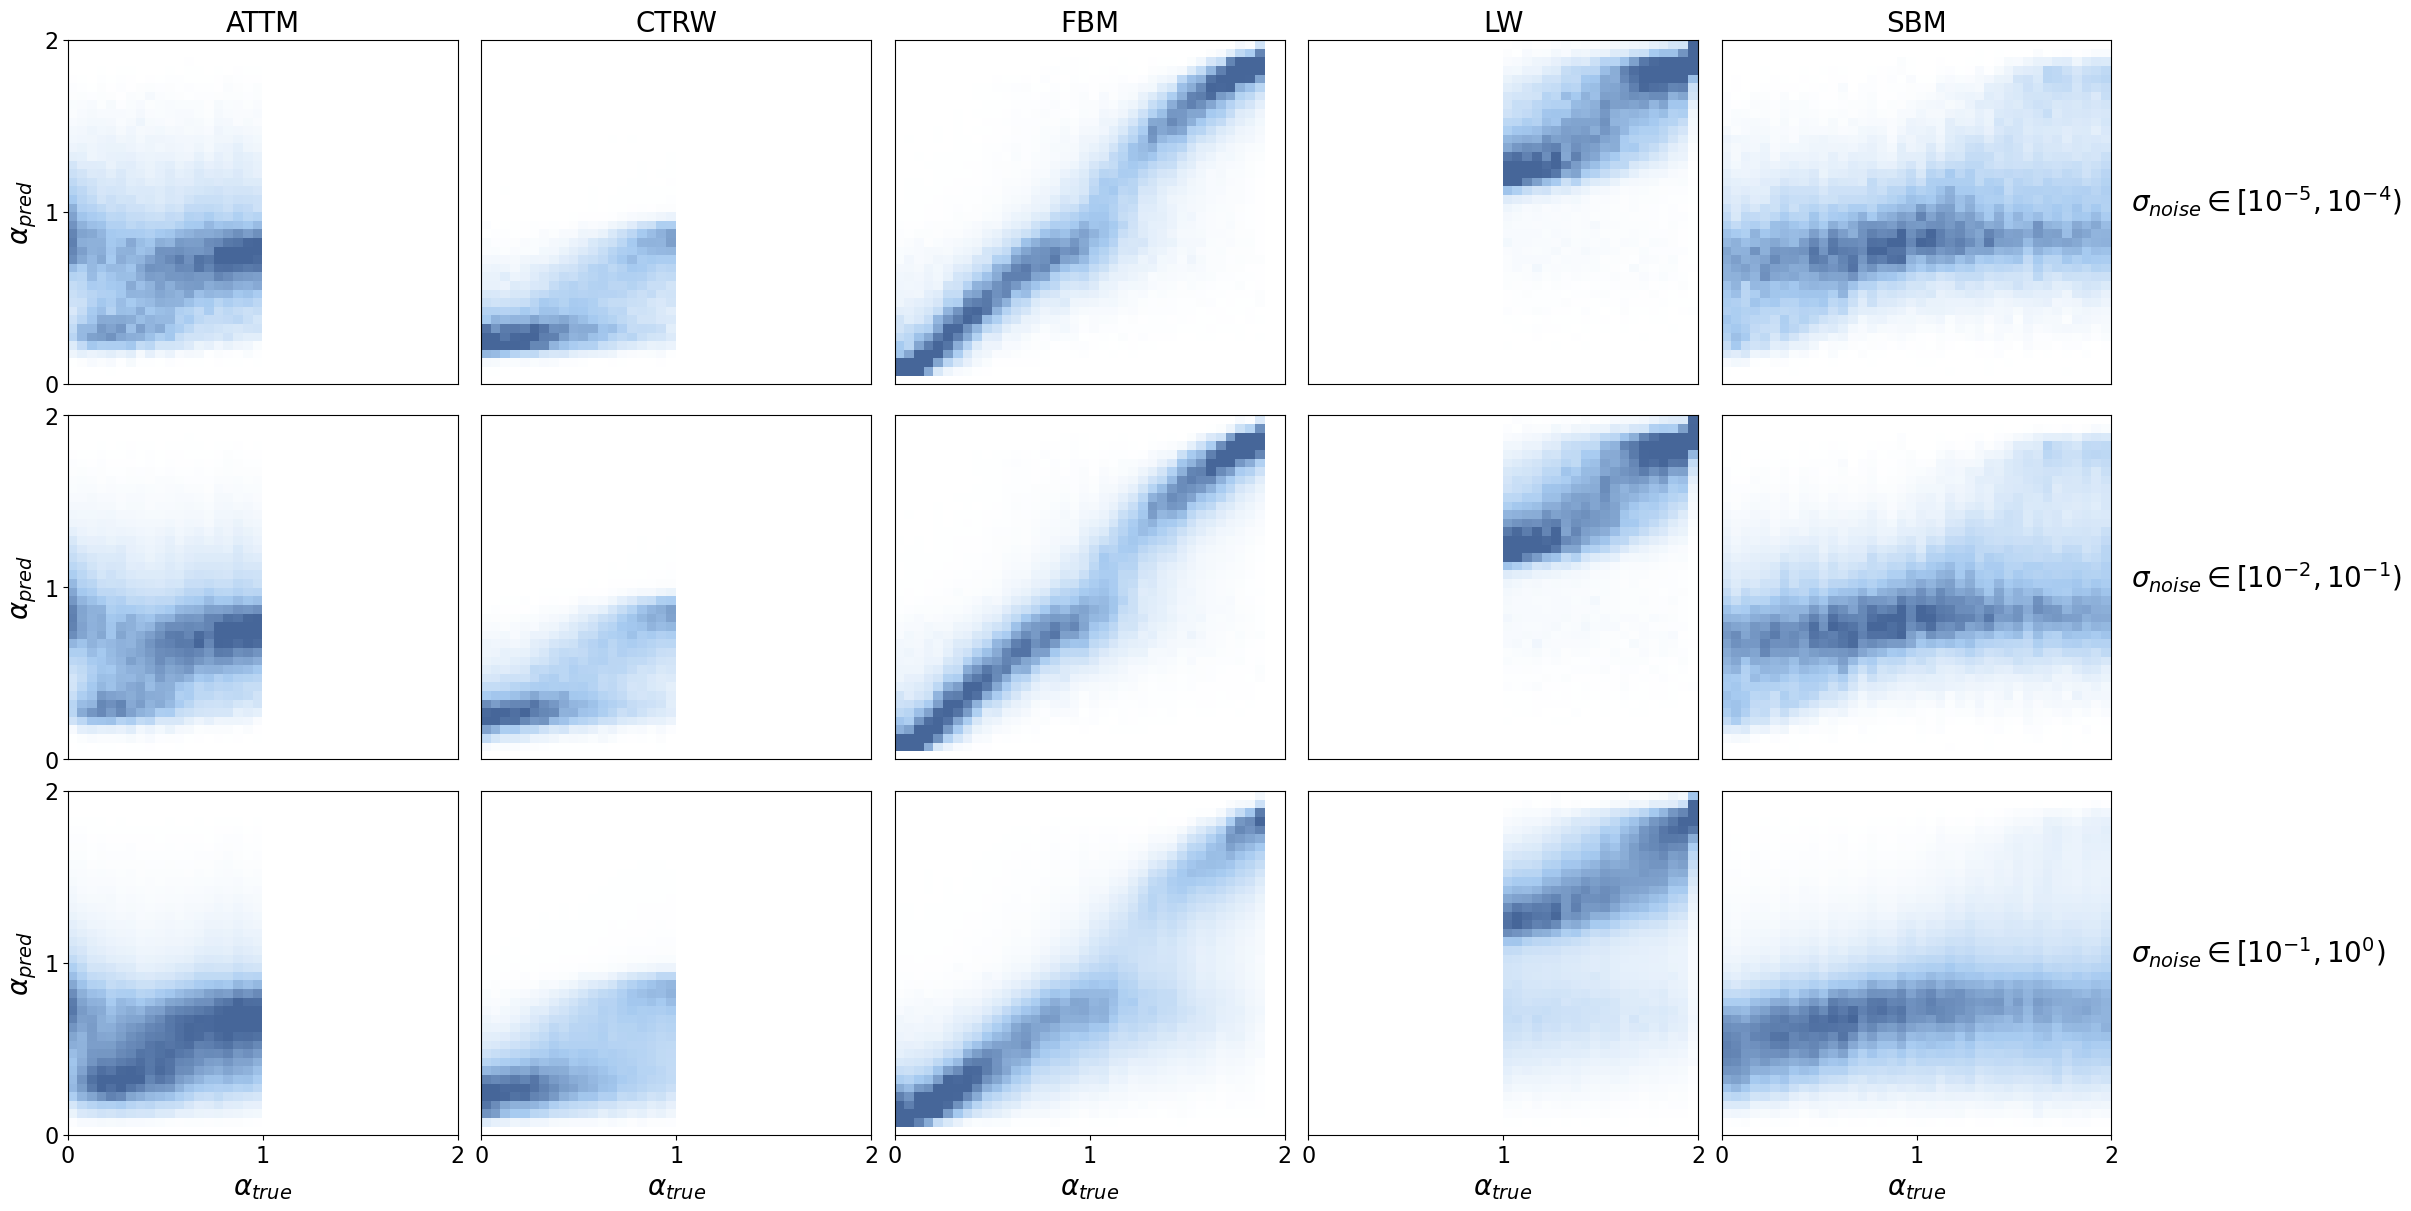

In [ ]:
#| code-fold: true
fig, axes = plt.subplots(3, 5, figsize=(6*fig_size, 3*fig_size),
                         constrained_layout=True)
ticks = (np.arange(0, 41, 20), [0, 1, 2])
ticksize = 16
fontsize = 20
noise_ranges = ["$[10^{-5}, 10^{-4})$",
                "$[10^{-2}, 10^{-1})$",
                "$[10^{-1}, 10^{0})$"]
vmax = {'attm': [0.9, 0.9, 0.9],
        'ctrw': [0.8, 0.9, 0.8],
        'fbm':  [0.3, 0.3, 0.5],
        'lw':   [0.6, 0.6, 0.6],
        'sbm':  [0.9, 0.9, 1]}

for m, data in pred_vs_true_by_model.items():
    if m == 'all': continue
    m_axes = axes[:, model_keys[m]]
    hist= data['hist']
    for i, ax in enumerate(m_axes):
        shape = hist[i].shape
        ax.pcolor(hist[i].T/hist[i].max(), vmin=0, vmax=vmax[m][i],
                  cmap=cmap_hist1, rasterized=True)
        
        if i == 0:
            ax.set_title(m.upper(), fontsize=fontsize)
            ax.tick_params(labeltop=False)
        if i == 1:
            ax.tick_params(labeltop=False)
            
        if i == 2:
            ax.set_xticks(*ticks)
            ax.set_xlabel(r'$\alpha_{true}$', fontsize=fontsize)
            ax.tick_params(labeltop=False, labelbottom=True)
        else:
            ax.set_xticks([])
            
        if model_keys[m] == 0: 
            ax.set_ylabel(r'$\alpha_{pred}$', fontsize=fontsize)
            ax.set_yticks(*ticks)
        else:
            ax.set_yticks([])
        
        ax.tick_params(labelsize=ticksize);
        
    if m == 'sbm':
        for ax, noise in zip(m_axes, noise_ranges):
            ax.text(42, 20, fr"$\sigma_{{noise}} \in$" + noise, fontsize=fontsize)

As expected, we observe a very nice $\alpha_{\text{pred}}$ vs $\alpha_{\text{true}}$ relationship for FBM and LW segments.

There is a clear tendency for STEP to predict $\alpha\approx0.8$ for SBM segments which is enhanced with noise. This is indicative that the model struggles to identify any clear behaviour and defaults to a quasi Brownian motion prediction.

In CTRW segments we find a similar pattern, where the model predicts $\alpha\approx0.25$, corresponding to nearly immobile particles. CTRW trajectories are characterized by immobilization with jumps at random times. In short segments, it is very likely that no jumps are shown and, thus, the model sees a static particle.

To a lesser extent, we observe a tendnency for ATTM trajectories to predict $\alpha\approx1$. ATTM trajectories are characterized by Brownian motion segments with random diffusion coefficients that change at random times. In short ATTM segments, it is very likely that there are no diffusion coefficient changes. Therefore, STEP only sees a pure Brownian motion segment for which the prediction of $\alpha\approx1$ is correct.

### MAE as function of $\sigma_{\text{noise}}$

Now we can look at the MAE of STEP and the TA-MSD baseline as function of the localization noise.

In [ ]:
noise_err, noise_err_std, x_err, counts = [], [], [], []
for low, high in tqdm(zip(bins_noise[:-1], bins_noise[1:])):
    mask = (rel_noise >= low) & (rel_noise <= high)
    x.append((low + high)/2)
    counts.append(mask.float().sum())
    noise_err.append(tensor([err[mask & ~err.isnan()].abs().mean()
                             for err in errors.values()]))
    noise_err_std.append(tensor([err[mask & ~err.isnan()].abs().std()
                                 for err in errors.values()]))
    
noise_err = torch.stack(noise_err)
noise_err_std = torch.stack(noise_err_std)
x_err = torch.stack(x_err)
counts = torch.stack(counts)

0it [00:00, ?it/s]

We can go a step further and compute the MAE for each diffusion model separately and as function of the noise.

In [ ]:
errors_model = {k: errors['full'][model == i] for k, i in model_keys.items()}

In [ ]:
mae_model_by_noise = {}
for m, i in model_keys.items():
    mae = []
    noise_model = rel_noise[model == i]
    for low, high in tqdm(zip(bins_noise[:-1], bins_noise[1:])):
        mask = (noise_model >= low) & (noise_model <= high)
        mae.append(errors_model[m][mask].abs().mean())
    mae_model_by_noise[m] = mae

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

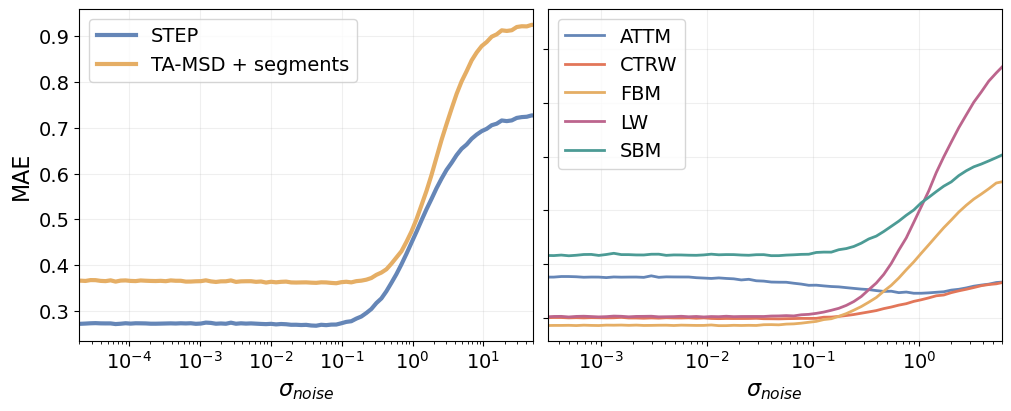

In [ ]:
#| code-fold: true
fig, ax = plt.subplots(1, 2, figsize=(2.5*fig_size, fig_size), constrained_layout=True)

labels = ['STEP', 'TA-MSD + segments']
idx = [0, 3]
sem = noise_err_std/counts.sqrt().unsqueeze(-1)
for i, (err, s) in enumerate(zip(noise_err.T[idx], sem.T[idx])):
    ax[0].semilogx(10**x_err, err, '-', linewidth=3., color=colors[2*i], label=labels[i])
    ax[0].fill_between(10**x_err, err - s, err + s, color=colors[2*i], alpha=0.3)
ax[0].legend(fontsize=14)
ax[0].set_xlabel(r"$\sigma_{noise}$", fontsize=16)
ax[0].set_ylabel("MAE", fontsize=16)
ax[0].set_xlim([2e-5, 50])

dx = bins_noise[1] - bins_noise[0]
x_noise_model = bins_noise[:-1] + dx
for i, (m, mae) in enumerate(mae_model_by_noise.items()):
    ax[1].semilogx(10**x_noise_model, mae, linewidth=2, color=colors[i], label=m.upper())
ax[1].set_xlim([10**(-3.5), 6])
ax[1].legend(fontsize=14)
ax[1].set_xlabel(r"$\sigma_{noise}$", fontsize=16)
ax[1].set_yticklabels([])

for a in ax:
    a.tick_params(labelsize=14)
    a.grid(alpha=alpha_grid)

Let's save the data of the figures to process them later.

In [ ]:
fig_name = "noise_analysis_alpha"
plot_path = (FIG_PATH/fig_name).with_suffix(".pkl")
plot_data = (noise_err, noise_err_std, x, counts)
with open(plot_path, 'wb') as f:
    pickle.dump(plot_data, f, protocol=pickle.HIGHEST_PROTOCOL)

fig_name = "noise_analysis_mae_models"
plot_path = (FIG_PATH/fig_name).with_suffix(".pkl")
plot_data = (mae_model_by_noise, bins_noise)
with open(plot_path, 'wb') as f:
    pickle.dump(plot_data, f, protocol=pickle.HIGHEST_PROTOCOL)

# Changepoint detection

In the [Brownian motion benchmark](https://borjarequena.github.io/step/tutorials/analysis_bm.html#changepoint-detection), we show a few ways to detect the position at which the trajectory behaviour changes. Here, we perform an analogous analysis to detect changes in the anomalous diffusion exponent $\alpha$.

We compare the results obtained by feeding the STEP predictions to the kernel changepoint detection algorithm provided by [ruptures](https://centre-borelli.github.io/ruptures-docs/), with running ruptures on top of an $\alpha$ estimation with the TA-MSD over a sliding window along the trajectory.

## Generate the data

In order to obtain a better insight about the strengths of the methods, we test them in trajectories with one single changepoint. Furthermore, we restrict ourselves to FBM trajectories, which has been the anomalous diffusion model for which our methods provided the best results.

In this way, we study how the changepoint position and difference between $\alpha$ in consecutive segments affects the performance.

In [ ]:
ds = create_segmentation_dataset(40000, dim=2, models=[2], noise=[0.], save=False)

## Get the predictions

Let's define some helping functions to keep our code clean.

In [ ]:
def make_batch(df, i, bs, col='x'):
    "Return a batch of samples from df."
    samples = [x.transpose(-1, 0) for x in ds.loc[i*bs:(i+1)*bs-1, col]]
    return torch.stack(samples, dim=0)

def predict_norm(model, x):
    "Get the `model` prediction normalizing the batch `x`."
    x_norm = normalize(x.to(default_device()))[0]
    return to_detach(model(x_norm).squeeze())

Let's gooo.

In [ ]:
bs = 100
n_batch = np.ceil(ds.shape[0]/bs).astype(int)
for i in tqdm(range(n_batch)):
    xb = make_batch(ds, i, bs)
    pred = predict_norm(learn_exp.model, xb)
    ds.loc[i*bs:(i+1)*bs-1, 'pred'] = np.array([p for p in pred],
                                               dtype=object)

  0%|          | 0/401 [00:00<?, ?it/s]

## Overall performance

Let's compute the Jaccard index (JI) using the STEP predictions and the $\alpha$ estimation with the TA-MSD.

We need to define a function to compute $\alpha$ along the trajectory with a sliding window.

In [ ]:
def swin_alpha_tamsd(x, win_size=10):
    "Computes the anomalous exponent with a sliding window over x."
    alphas = []
    for i in range(len(x) - win_size):
        alpha = anomalous_exponent_tamsd(x[i:i + win_size],
                                         t_lag=np.arange(2, win_size//2))
        alphas.append(alpha)
    return np.array(alphas)

To ease the code readability, we define a function to combine two dictionaries together (adhoc for our purposes).

In [ ]:
def merge_dict(dict_1, dict_2):
    merge = {}
    for k, v1 in dict_1.items():
        v2 = dict_2.get(k, [])
        if isinstance(v1, Iterable) and isinstance(v2, Iterable):
            merge[k] = [*v1, *v2]
        elif isinstance(v1, Iterable):
            merge[k] = [*v1, v2]
        elif isinstance(v2, Iterable):
            merge[k] = [v1, *v2]
        else:
            merge[k] = [v1, v2]
    return merge

Now we process every trajectory and retrieve the changepoints with ruptures using both inputs.

In [ ]:
method_pen = {'pred': 2., 'tamsd': 8.}
win_size = 30
methods = list(method_pen.keys())
threshold = 20

metrics_method = {m: {} for m in methods}
for i, row in tqdm(ds.iterrows()):
    traj = normalize(row.x.T.unsqueeze(0))[0]
    pred, true_cp = row.pred.numpy(), row.cp.numpy()
    alphas_tamsd = swin_alpha_tamsd(traj.squeeze(), win_size=win_size)

    for m in methods:
        seg_data = (pred if m == 'pred' 
                    else alphas_tamsd if m == 'tamsd'
                    else None)
        pred_cp = ruptures_cp(seg_data, pen=method_pen[m], min_size=5)
        if m == 'tamsd':
            # Add half window size to the prediction from TA-MSD
            pred_cp = [p + win_size//2 for p in pred_cp]
        metrics = evaluate_cp_prediction(true_cp, pred_cp,
                                         changepoint_threshold=threshold)
        metrics_method[m] = merge_dict(metrics, metrics_method[m])

        for k, v in metrics.items():
            if metrics['tp']:
                ds.loc[i, f'cp_{m}_{k}'] = v[0] if k == 'sq_error' else v
            else:
                ds.loc[i, f'cp_{m}_{k}'] = -1 if k == 'sq_error' else v

Now we can compute the overall JI and MSE for both approaches over the whole test set. 

In [ ]:
method_mse, method_j_idx = {}, {}
for m, v in metrics_method.items():
    method_mse[m] = np.mean(v['sq_error'])
    tp, fp, fn = np.sum(v['tp']), np.sum(v['fp']), np.sum(v['fn'])
    method_j_idx[m] = jaccard_index(tp, fp, fn)

In [ ]:
# code-fold: true
print("Jaccard index:")
for m, ji in method_j_idx.items():
    print(f"  {m}: {ji:.3f}")
print("MSE:")
for m, ji in method_mse.items():
    print(f"  {m}: {ji:.3f}")

Jaccard index:
  pred: 0.515
  tamsd: 0.297
MSE:
  pred: 35.011
  tamsd: 71.276


Running the changepoint detection algorithm over the STEP predictions provides a massive advantage with respect to the sliding window TA-MSD baseline. We reduce the changepoint prediction error by about $30\%$ and we cut the MSE by half.

However, the changepoint detection task for $\alpha$ proves to be significantly more challenging than for $D$, where we achieve mean JI over 0.8, as we saw in the [Brownian motion benchmark](https://borjarequena.github.io/step/tutorials/analysis_bm.html#overall-performance-1).

## Difference between segments

Just like we did for the diffusion coefficient, we can look at how the jaccard index behaves as function of the difference between consecutive segments.

We start by computing the difference between consecutive $\alpha$ in each trajectory.

In [ ]:
ds['cp'] = ds.cp.apply(lambda x: x[0].item())
ds['alpha_diff'] = ds.exps.apply(lambda x: round((x[1] - x[0]).item(), 2))

Now we can compute the metrics.

In [ ]:
differences = np.unique(ds.alpha_diff)
j_idx_by_diff = {m: [] for m in methods}
for diff in differences:
    mask = ds.alpha_diff == diff
    for m in methods:
        tp = ds.loc[mask, f'cp_{m}_tp'].sum()
        fp = ds.loc[mask, f'cp_{m}_fp'].sum()
        fn = ds.loc[mask, f'cp_{m}_fn'].sum()
        j_idx_by_diff[m].append(jaccard_index(tp, fp, fn))

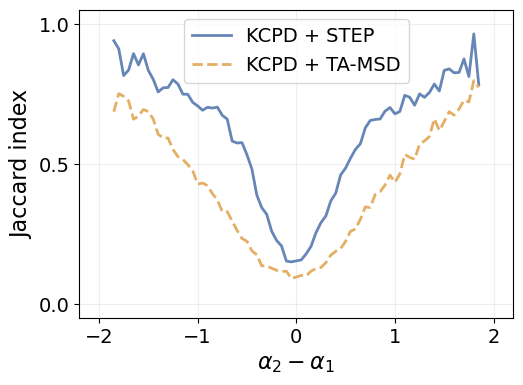

In [ ]:
#| code-fold: true
method_color = {'pred': colors[0], 'displ': colors_light[3], 'tamsd': colors[2]}
method_label = {'pred': 'KCPD + STEP', 'displ': 'KCPD + displ', 'tamsd': 'KCPD + TA-MSD'}
method_ls = {'pred': 'solid', 'displ': 'dashed', 'tamsd': 'dashed'}

fig = plt.figure(figsize=(1.4*fig_size, fig_size))
for m in methods:
    plt.plot(differences, j_idx_by_diff[m], linewidth=linewidth, label=method_label[m],
             color=method_color[m], linestyle=method_ls[m])
plt.legend(fontsize=14)
plt.grid(alpha=alpha_grid)
plt.xlim([-2.2, 2.2])
plt.xticks([-2, -1, 0, 1, 2])
plt.ylim([-0.05, 1.05])
plt.yticks([0., 0.5, 1.])
plt.xlabel(r"$\alpha_2 - \alpha_1$", fontsize=16)
plt.ylabel("Jaccard index", fontsize=16)
plt.tick_params(labelsize=14)

### Change point position

In [ ]:
bins_cp = np.arange(10, 200, 10)
j_idx_by_position = {m: [] for m in methods}
for low, high in zip(bins_cp[:-1], bins_cp[1:]):
    mask = (low <= ds.cp) & (ds.cp < high)
    for m in methods:
        tp = ds.loc[mask, f'cp_{m}_tp'].sum()
        fp = ds.loc[mask, f'cp_{m}_fp'].sum()
        fn = ds.loc[mask, f'cp_{m}_fn'].sum()
        j_idx_by_position[m].append(jaccard_index(tp, fp, fn))

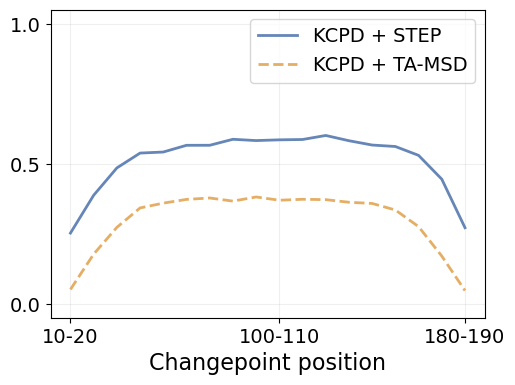

In [ ]:
#| code-fold: true
fig = plt.figure(figsize=(1.4*fig_size, fig_size))
for m in methods:
    plt.plot(j_idx_by_position[m], linewidth=linewidth, label=method_label[m],
              color=method_color[m], linestyle=method_ls[m])
x_tick_idx = np.array([0, 9, 17])
plt.xticks(x_tick_idx, 
           [f'{low}-{high}' for low, high in zip(bins_cp[x_tick_idx], bins_cp[x_tick_idx+1])])
plt.grid(alpha=alpha_grid)
plt.legend(fontsize=14)
plt.ylim([-0.05, 1.05])
plt.yticks([0., 0.5, 1.])
plt.xlabel("Changepoint position", fontsize=16)
plt.tick_params(labelsize=14)